## Multilabel Classification with scikit-multilearn

### 1. Introduction

We typically group supervised machine learning problems into classification and regression problems. Within the classification problems sometimes, multiclass classification models are encountered where the classification is not binary but we have to assign a class from `n` choices. 

In multilabel classification, instead of one target variable $y$, we have multiple target variables $y_1$, $y_2$, ..., $y_n$. For example there can be multiple objects in an image and we need to correctly classify them all or we are attempting predict which combination of a product that a customer would buy. 

Certain decision tree based algorithms in [Scikit-Learn](http://scikit-learn.org/stable/modules/multiclass.html) are naturally able to handle multilabel classification. In this post we explore the [scikit-multilearn library](http://scikit.ml/) which leverages Scikit-Learn and is built specifically for multilabel problems. 


### 2. Datasets

We use the **MediaMill** dataset to explore different multilabel algorithms available in Scikit-Multilearn. Our goal is not to optimize classifier performance but to explore the various algorithms applicable to multilabel classification problems. The dataset is reasonable with over 30k train points and 12k test points. There are 120 features and 101 labels. 

This dataset was chosen in order to work with a fairly large dataset to illustrate difficulties in multilabel classification instead of a toy example. In particular when there are $N$ labels, the search space increases exponentially to $2^N$. A list of multilabel datasets can be found at Manik Varma's [Extreme Classification Repository](http://manikvarma.org/downloads/XC/XMLRepository.html). The data is provided in sparse format and the authors only provide Matlab scripts to convert them; some data wrangling is needed in python to handle them. 




In [ ]:
from scipy import sparse
import gc

#f = open(r'C:\Users\david\Downloads\Mediamill\Mediamill_data.txt',
#'r',encoding='utf-8')
f = open(r'C:\Users\kaoyuant\Downloads\Mediamill\Mediamill_data.txt',
         'r',encoding='utf-8')

size = f.readline()
nrows, nfeature,nlabel = [int(s) for s in size.split()]
x_m = [[] for i in range(nrows)]
pos = [[] for i in range(nrows)]
y_m = [[] for i in range(nrows)]

for i in range(nrows):
    line = f.readline()
    temp=[s for s in line.split(sep=' ')]
    pos[i]=[int(s.split(':')[0]) for s in temp[1:]]
    x_m[i]=[float(s.split(':')[1]) for s in temp[1:]]
    for s in temp[0].split(','):
        try:
            int(s)
            y_m[i]=[ int(s) for s in temp[0].split(',')]
        except:
            y_m[i]=[]
          
      


#f = open(r'C:\Users\david\Downloads\Mediamill\Mediamill_trSplit.txt',
#'r',encoding='utf-8')
f = open(r'C:\Users\kaoyuant\Downloads\Mediamill\Mediamill_trSplit.txt',
         'r',encoding='utf-8')
train=f.readlines()

#f = open(r'C:\Users\david\Downloads\Mediamill\Mediamill_tstSplit.txt',
#'r',encoding='utf-8')
f = open(r'C:\Users\kaoyuant\Downloads\Mediamill\Mediamill_tstSplit.txt',
         'r',encoding='utf-8')
test=f.readlines()


select=0
train_=[int(s.split()[select])-1 for s in train]
test_=[int(s.split()[select])-1 for s in test]

xm_train=[x_m[i] for i in train_]
ym_train=[y_m[i] for i in train_]

xm_test=[x_m[i] for i in test_]
ym_test=[y_m[i] for i in test_]



x_train=sparse.lil_matrix((len(train_),nfeature))
for i in range(len(train_)):
    for j in range(len(pos[i])):
        x_train[i,pos[i][j]]=xm_train[i][j]

x_test=sparse.lil_matrix((len(test_),nfeature))
for i in range(len(test_)):
    for j in range(len(pos[i])):
        x_test[i,pos[i][j]]=xm_test[i][j]

del x_m, xm_train, pos,xm_test
gc.collect()

y_train=sparse.lil_matrix((len(train_),nlabel))
for i in range(len(train_)):
    for j in ym_train[i]:
        y_train[i,j]=1

y_test=sparse.lil_matrix((len(test_),nlabel))
for i in range(len(test_)):
    for j in ym_test[i]:
        y_test[i,j]=1

del y_m, ym_train, ym_test
gc.collect()  


### 3. Label Graph

When the label space is large, we can try to explore it using graph methods. Each label is a node in the graph and an edge exists when labels co-occur, weighted by the frequency of co-occurence.  

In [42]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True,
                                              include_self_edges=False)

label_names=[i for i in range(nlabel)]
edge_map = graph_builder.transform(y_train)
print("{} labels, {} edges".format(len(label_names), len(edge_map)))


101 labels, 2213 edges


Once we have constructed the label graph, we can apply graph algorithms on it to explore and understand it. 

One possibility is to cluster similar labels together so that they are processed together by the multilabel classification algorithms. Community detection methods such as the [Louvain algorithm](https://en.wikipedia.org/wiki/Louvain_Modularity) allow us to cluster the label graph. This is implemented in the `NetworkXLabelGraphClusterer` with the parameter `methods = louvain`.

In [81]:

from skmultilearn.cluster import NetworkXLabelGraphClusterer

# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }
clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')


In [82]:
partition = clusterer.fit_predict(x_train,y_train)
membership_vector = to_membership_vector(partition)
print('There are', len(partition),'clusters')

There are 3 clusters


Our graph can be visualized with NetworkX. We use the force or spring layout for better visibility. 

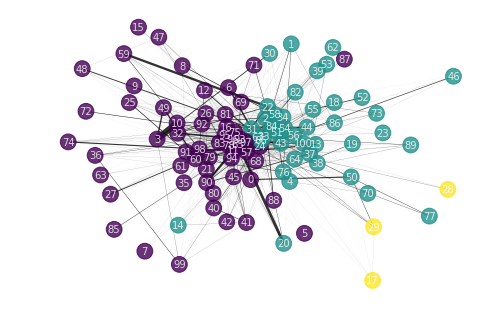

In [83]:
import networkx as nx
names_dict = dict(enumerate(x for x in label_names))
import matplotlib.pyplot as plt
%matplotlib inline
nx.draw(
    clusterer.graph_,
    pos=nx.spring_layout(clusterer.graph_,k1),
    labels=names_dict,
    with_labels = True,
    width = [10*x/y_train.shape[0] for x in clusterer.weights_['weight']],
    node_color = [membership_vector[i] for i in range(y_train.shape[1])],
    cmap=plt.cm.viridis,
    node_size=250,
    font_size=10,
    font_color='white',
    alpha=0.8
)

We get 3 clusters. It might make sense to group them together when we send them to the multilabel  algorithm. Certain labels have lower centrality, indicating less influence from other labels. It is possible to predict these labels first before predicting the more central labels when using the chained classifier algorithm (see below).

### 3. Metric  

Before going into the details of each multilabel classification method, we select a metric to gauge how well the algorithm is performing. Similar to a classification problem it is possible to use `Hamming Loss`, `Accuracy`, `Precision`, `Jaccard Similarity`, `Recall`, and `F1 Score`. These are available from Scikit-Learn. 

Going forward we'll chose the `F1 Score` as it averages both `Precision` and `Recall`. We set the parameter `average = micro` to calculate metrics globally. There are many labels and some labels are not predicted; using `average = weighted` will result in the score for certain labels to be set to `0` before averaging.

It is also helpful to plot the confusion matrix to understand how the classifier is performing, but in our case there are too many labels to visualize.




In [6]:
Image of confusion matrix 

SyntaxError: invalid syntax (<ipython-input-6-853b10b3eedc>, line 1)

### 4. Multilabel Classifiers - Algorithm Adaptation

Algorithm Adaptation, as indicated by it's name, extend single label classification to the multi-label context, usually by changing the cost or decision functions. 

#### Algorithm Adaptation - MLkNN

#### Algorithm Adaptation - BRkNNaClassifier

### 5. Multilabel Classifiers - Problem Transformation

#### Problem Transformation : Binary Relevance 

Binary relevance is simple; each target variable ($y_1$, $y_2$,..,$y_n$) is treated independently and we are reduced to $n$ classification problems. `Scikit-Multilearn` implements this for us, saving us the hassle of splitting the dataset and training each of them separately.  

In [25]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier
import time

start=time.time()
classifier = BinaryRelevance(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
)

classifier.fit(x_train, y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')



training time taken:  767.0 seconds


In [26]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

prediction time taken:  59.0 seconds


In [27]:
import sklearn.metrics as metrics

br_f1=metrics.f1_score(y_test, y_hat, average='micro')
br_hamm=metrics.hamming_loss(y_test,y_hat)
print('Binary Relevance F1-score:',round(br_f1,3))
print('Binary Relevance Hamming Loss:',round(br_hamm,3))

Binary Relevance F1-score: 0.591
Binary Relevance Hamming Loss: 0.028


#### Problem Transformation - Label Powerset

This method transforms the problem into a multiclass classification problem; the target variables ($y_1$, $y_2$,..,$y_n$) are combined and each combination is treated as a unique class. This method will produce many classes. 

In [49]:
from skmultilearn.problem_transform import LabelPowerset

classifier = LabelPowerset(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
)

start=time.time()
classifier.fit(x_train, y_train)
print('training time taken: ',round(time.time()-start,0),'seconds')

training time taken:  625.0 seconds


In [50]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

prediction time taken:  134.0 seconds


In [51]:

lp_f1=metrics.f1_score(y_test, y_hat, average='micro')
lp_hamm=metrics.hamming_loss(y_test,y_hat)
print('Label Powerset F1-score:',round(lp_f1,3))
print('Label Powerset Hamming Loss:',round(lp_hamm,3))

Label Powerset F1-score: 0.582
Label Powerset Hamming Loss: 0.031


#### Problem Transformation - Classifier Chains 

Classifier chains are akin to binary relevance, however the target variables ($y_1$, $y_2$,..,$y_n$) are not fully independent. 

In [52]:
from skmultilearn.problem_transform import ClassifierChain

classifier = ClassifierChain(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
)
start=time.time()
classifier.fit(x_train,y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')

training time taken:  481.0 seconds


In [53]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

prediction time taken:  12.0 seconds


In [54]:
cc_f1=metrics.f1_score(y_test, y_hat, average='micro')
cc_hamm=metrics.hamming_loss(y_test,y_hat)
print('Classifier Chain F1-score:',round(cc_f1,3))
print('Classifier Chain Hamming Loss:',round(cc_hamm,3))

Classifier Chain F1-score: 0.579
Classifier Chain Hamming Loss: 0.028


In [95]:
from operator import itemgetter
sorted_deg = [s[0] for s in sorted(nx.betweenness_centrality(clusterer.graph_).items(),
                                   key=itemgetter(1))]
classifier = ClassifierChain(
    classifier = RandomForestClassifier(),
    require_dense = [False, True],
    order=sorted_deg
)
start=time.time()
classifier.fit(x_train,y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')

training time taken:  476.0 seconds


In [96]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

prediction time taken:  12.0 seconds


In [97]:
cco_f1=metrics.f1_score(y_test, y_hat, average='micro')
cco_hamm=metrics.hamming_loss(y_test,y_hat)
print('Classifier Chain Ordered F1-score:',round(cco_f1,3))
print('Classifier Chain Ordered Hamming Loss:',round(cco_hamm,3))

Classifier Chain Ordered F1-score: 0.019
Classifier Chain Ordered Hamming Loss: 0.063


In [112]:
rev_sorted_deg = [s[0] for s in sorted(nx.betweenness_centrality(clusterer.graph_).items(),
                                   key=itemgetter(1),
                 reverse=True)]

classifier = ClassifierChain(
    classifier = RandomForestClassifier(),
    require_dense = [False, True],
    order=rev_sorted_deg
)
start=time.time()
classifier.fit(x_train,y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')

training time taken:  419.0 seconds


In [ ]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

In [ ]:
ccr_f1=metrics.f1_score(y_test, y_hat, average='micro')
ccr_hamm=metrics.hamming_loss(y_test,y_hat)
print('Classifier Chain Reverse Ordered F1-score:',round(ccr_f1,3))
print('Classifier Chain Reverse Ordered Hamming Loss:',round(ccr_hamm,3))

In [109]:
min(sorted_deg)

0

### 6. Multilabel Classifiers - Ensembles of Classifiers

#### Ensembles of Classifiers - RakelD

#### Ensembles of Classifiers - Majority Voting Classifier

### 7. Extreme Multilabel Classification

We use the AmazonCat-13K dataset to explore different multilabel algorithms available in Scikit-Multilearn. Our goal is not to optimize classifier performance but to explore the various algorithms applicable to multilabel classification problems. The dataset if fairly large with over 1.1M train points and 300k test points. There are over 200k features and 13k labels. 

This dataset was chosen in order to work with a fairly large dataset to illustrate difficulties in multilabel classification instead of a toy example. In particular when there are $N$ labels, the search space increases exponentially to $2^N$. A list of multilabel datasets can be found at Manik Varma's [Extreme Classification Repository](http://manikvarma.org/downloads/XC/XMLRepository.html). The data is provided in sparse format and the authors only provide Matlab scripts to convert them; some data wrangling is needed in python to handle them. 


In [1]:
from scipy import sparse
import gc

#f = open(r'C:\Users\david\Downloads\RCV1-x\rcv1x_train.txt', 'r',encoding='utf-8')
f = open(r'C:\Users\kaoyuant\Downloads\RCV1-x\rcv1x_train.txt', 'r',encoding='utf-8')
   
    
size = f.readline()
nrows, nfeature,nlabel = [int(s) for s in size.split()]
x_m = [[] for i in range(nrows)]
pos = [[] for i in range(nrows)]
y_m = [[] for i in range(nrows)]

for i in range(nrows):
    line = f.readline()
    temp=[s for s in line.split(sep=' ')]
    pos[i]=[int(s.split(':')[0]) for s in temp[1:]]
    x_m[i]=[float(s.split(':')[1]) for s in temp[1:]]
    for s in temp[0].split(','):
        try:
            int(s)
            y_m[i]=[ int(s) for s in temp[0].split(',')]
        except:
            y_m[i]=[]
          
x_train=sparse.lil_matrix((nrows,nfeature))
for i in range(nrows):
    for j in range(len(pos[i])):
        x_train[i,pos[i][j]]=x_m[i][j]

del x_m,pos
gc.collect()

y_train=sparse.lil_matrix((nrows,nlabel))
for i in range(nrows):
    for j in y_m[i]:
        y_train[i,j]=1

del y_m
gc.collect()  



0

In [ ]:


#f = open(r'C:\Users\david\Downloads\RCV1-x\rcv1x_test.txt', 'r',encoding='utf-8')
f = open(r'C:\Users\kaoyuant\Downloads\RCV1-x\rcv1x_test.txt', 'r',encoding='utf-8')

size = f.readline()
nrows, nfeature,nlabel = [int(s) for s in size.split()]
x_m = [[] for i in range(nrows)]
pos = [[] for i in range(nrows)]
y_m = [[] for i in range(nrows)]

for i in range(nrows):
    line = f.readline()
    temp=[s for s in line.split(sep=' ')]
    pos[i]=[int(s.split(':')[0]) for s in temp[1:]]
    x_m[i]=[float(s.split(':')[1]) for s in temp[1:]]
    for s in temp[0].split(','):
        try:
            int(s)
            y_m[i]=[ int(s) for s in temp[0].split(',')]
        except:
            y_m[i]=[]
          

x_test=sparse.lil_matrix((nrows,nfeature))
for i in range(nrows):
    for j in range(len(pos[i])):
        x_test[i,pos[i][j]]=x_m[i][j]

del x_m,pos
gc.collect()

y_test=sparse.lil_matrix((nrows,nlabel))
for i in range(nrows):
    for j in y_m[i]:
        y_test[i,j]=1

del y_m
gc.collect()  

In [ ]:
prod = [(x, y) for x in range(nrows) for y in pos] # combinations
r = [x for (x, y) in prod] # x_coordinate
c = [y for (x, y) in prod] # y_coordinate
data = [1] * len(r)
m = scipy.sparse.coo_matrix((data, (r, c)), shape=(nrows, nfeature))

### FastXML

In [5]:
import os
os.chdir('/Users/davidten/github/fastxml')

from fastxml import Trainer, Inferencer


In [6]:
trainer = Trainer(n_trees=32, n_jobs=-1)
